In [1]:
%load_ext autoreload
%autoreload 2
import pyvisa
import time
from PyTLPMX import TLPMX
import numpy as np
import numpy.matlib
import clr
from matplotlib import pyplot as plt
from datetime import datetime
from timeit import default_timer as timer
from scipy.optimize import curve_fit

clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.DeviceManagerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericPiezoCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericMotorCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.KCube.PositionAlignerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.KCube.PiezoCLI.dll")

# Import CLIs
from Thorlabs.MotionControl.DeviceManagerCLI import *
from Thorlabs.MotionControl.GenericMotorCLI import *
from Thorlabs.MotionControl.KCube.PositionAlignerCLI import *
from Thorlabs.MotionControl.KCube.PiezoCLI import *
from Thorlabs.MotionControl.GenericPiezoCLI.Piezo import *
from System import Decimal 
from pyximc import *
from module import *

In [4]:
# connect to lock-in amps
rm = pyvisa.ResourceManager()
amp1 = rm.open_resource('GPIB0::8::INSTR')
amp2 = rm.open_resource('GPIB0::9::INSTR')
print(rm.list_resources())
#liamp = connectLIA(rm) 

('GPIB0::8::INSTR', 'GPIB0::9::INSTR')


In [2]:
# Connect to piezo controller
piezo = connectKPZ("29252602")
print("Setting Zero Point")
piezo.SetZero()

Connecting to device
Getting device info
KPZ101 Piezo Drive
Setting Zero Point


In [33]:
numScans = 10
positions = np.array(np.linspace(0, 20, 2))
shifts, TM_paras, TE_paras = estimateShift(piezo, amp1, amp2, numScans, positions)
print(f"Mean shift: {np.mean(shifts)}")

Scan 1

Moved to 0
Taking measurement..
TM Signal: 0.0031415618181818185

TE Signal: 0.004161063636363636

Moved to 75
Taking measurement..
TM Signal: -0.0036241951515151513

TE Signal: -0.004839506666666667



C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


shift: 0.04043069211200567

Scan 2

Moved to 0
Taking measurement..
TM Signal: 0.0033337569696969696

TE Signal: 0.003880048484848485

Moved to 75
Taking measurement..
TM Signal: -0.004404091515151515

TE Signal: -0.005715515151515152

shift: 0.5295827274981928

Scan 3

Moved to 0
Taking measurement..
TM Signal: 0.0017558241818181818

TE Signal: 0.00533742606060606

Moved to 75
Taking measurement..
TM Signal: -0.004140949696969696

TE Signal: -0.0042158101151515154

shift: -5.218866420722226

Scan 4

Moved to 0
Taking measurement..
TM Signal: 0.0023973050909090908

TE Signal: 0.004396229696969697

Moved to 75
Taking measurement..
TM Signal: -0.004223444242424242

TE Signal: -0.004810952848484849

shift: -2.307771772961286

Scan 5

Moved to 0
Taking measurement..
TM Signal: 0.003618018787878788

TE Signal: 0.002458599696969697

Moved to 75
Taking measurement..
TM Signal: -0.00449848303030303

TE Signal: -0.003563003090909091

shift: 0.7492859178465068

Scan 6

Moved to 0.002288888210699

Shift estimate: -2.4374672086776754 um

Avg TM scan gradient: -0.35101099721590917 V/mm
Avg TE scan gradient: -0.44603210921022723 V/mm
0.061688903766615816
0.1052092814240887


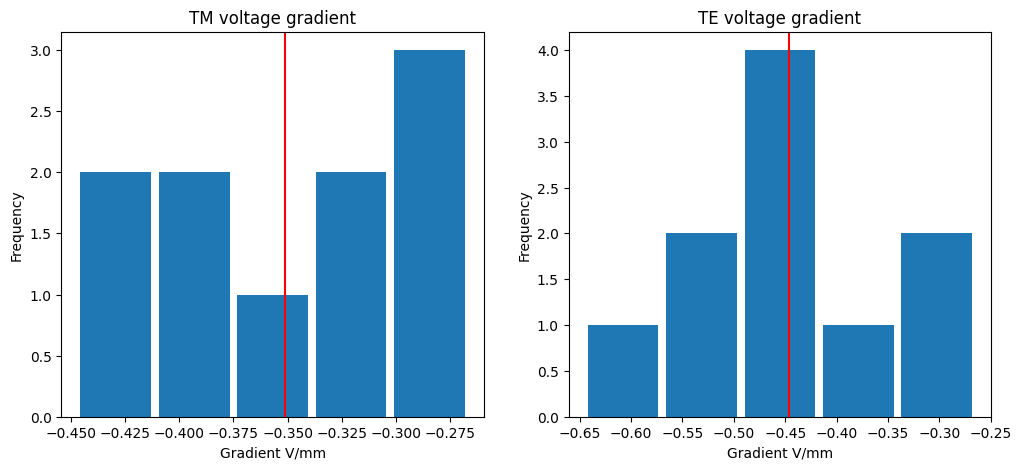

In [35]:
# Analyse gradients

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


avg_TM_g = np.mean(TM_paras[:, 0]) 
avg_TM_y = np.mean(TM_paras[:, 1]) 

avg_TE_g = np.mean(TE_paras[:, 0]) 
avg_TE_y = np.mean(TE_paras[:, 1]) 

print(f"Shift estimate: {np.mean(shifts)} um\n")

print(f"Avg TM scan gradient: {avg_TM_g*1000} V/mm")
print(f"Avg TE scan gradient: {avg_TE_g*1000} V/mm")

TM_fit = avg_TM_g*np.array(positions) + avg_TM_y
TE_fit = avg_TE_g*np.array(positions) + avg_TE_y

bins = 5
ax1.hist(TM_paras[:, 0]*1000, bins, rwidth=0.9)
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Gradient V/mm")
ax1.axvline(np.mean(TM_paras[:, 0]*1000), color="red")
ax1.set_title("TM voltage gradient")

ax2.hist(TE_paras[:, 0]*1000, bins, rwidth=0.9)
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Gradient V/mm")
ax2.axvline(np.mean(TE_paras[:, 0]*1000), color="red")
ax2.set_title("TE voltage gradient")
print(np.std(TM_paras[:, 0]*1000))
print(np.std(TE_paras[:, 0]*1000))
plt.show()

4.913372202848256


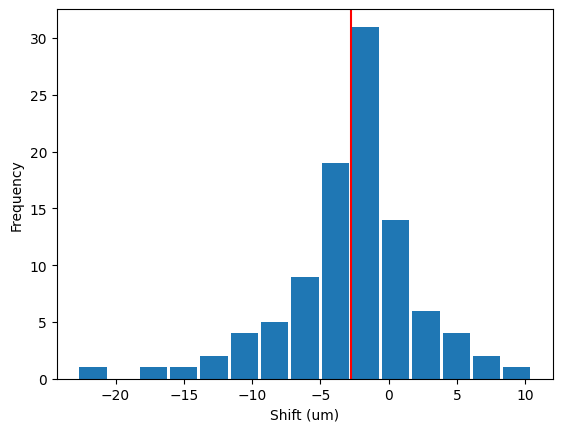

In [42]:
fig, ax = plt.subplots()
ax.hist(shifts, 15, rwidth=0.9)
ax.set_ylabel("Frequency")
ax.set_xlabel("Shift (um)")
ax.axvline(np.mean(shifts), color="red")
print(np.std(shifts))

In [43]:
now = datetime.now()
current_time = now.strftime("%H;%M")
file_prefix = "{}-".format("GHS_CONTROL_DATA_") + current_time

figName = file_prefix + ".png"
    
# Save fig to png in figs folder
os.chdir("Figs")
fig.savefig(figName)
os.chdir("..")
print("Figure Saved")

# Save data to CSV in csv folder
os.chdir("CSVs")
csvFileName = file_prefix + ".csv"
with open(csvFileName, "w") as txt_file:   
 for i in range(len(shifts)):
        txt_file.write("{}".format(shifts[i]) + "\n")

 # Return to main folder
os.chdir("..")
print("CSV Saved")

Figure Saved
CSV Saved


In [ ]:
# calculate z-score normalisation of data
z_ydiffs = (ydiffs-mean_ydiffs)/std_ydiffs
z_powsums = (powSums-mean_powsums)/std_powsums

In [28]:
# DUAL BEAM SCAN

# Initialise array of positions (in um) to take readings from
positions = np.array(np.linspace(0, 20, 5))

# RUN DUAL BEAM SCAN
TM_signal, TM_err, TE_signal, TE_err = dualBeamScan(amp1, amp2, positions, piezo)

# perform least squares regression
# Get parameters and covariance from curve_fit
TM_para, TM_pcov = curve_fit(linearFunc, positions, TM_signal)
TE_para, TE_pcov = curve_fit(linearFunc, positions, TE_signal)

# Calculate shift from x-intercepts
TM_intercept = -TM_para[1] / TM_para[0]
TE_intercept = -TE_para[1] / TE_para[0]
shift = TM_intercept - TE_intercept

Moved to 0
Taking measurement..
TM Signal: 0.001697681515151515

TE Signal: 0.005830722424242425

Moved to 18.7620166631062
Taking measurement..
TM Signal: 0.0014534649696969697

TE Signal: 0.0045878690909090915

Moved to 37.5240333262124
Taking measurement..
TM Signal: -0.00029987409090909096

TE Signal: 0.002312575151515152

Moved to 56.2906277657399
Taking measurement..
TM Signal: -0.0027416043749999997

TE Signal: -0.0006390549999999999

Moved to 75
Taking measurement..
TM Signal: -0.00585566303030303

TE Signal: -0.0033933181818181822




Shift: -6.651180219774864 um
-0.00038603516912636706
-0.00047350010594522424


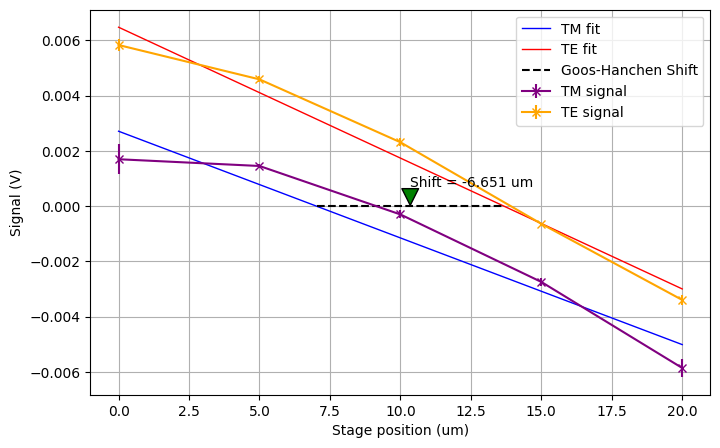

In [32]:
# PLOT RESULTS
fig, ax = plt.subplots(figsize=(8,5))

# calculate error and plot graph
ax.errorbar(positions, TM_signal, TM_err, fmt='x-', color="purple")
TM_fit = TM_para[0]*np.array(positions) + TM_para[1]
ax.plot(positions, TM_fit, 'b', label='OLS TM model', linewidth=1)

ax.errorbar(positions, TE_signal, TE_err, fmt='x-', color="orange")
TE_fit = TE_para[0]*np.array(positions) + TE_para[1]
ax.plot(positions, TE_fit, 'r', label='OLS TE model', linewidth=1) 

# Labels
ax.set_xlabel('Stage position (um)')
ax.set_ylabel('Signal (V)')
ax.grid()

print("\nShift: {} um".format(shift))

# Label shift
shiftLabel = "Shift = {} um".format(np.round(shift, 3))
xCoord = np.mean([TM_intercept, TE_intercept])
yCoord = ax.get_ylim()[1]*0.1
ax.hlines(0, TM_intercept, TE_intercept, colors='black', linestyles='dashed')
ax.annotate(shiftLabel, xy =(xCoord, 0), 
                xytext =(xCoord, yCoord),  
                arrowprops = dict(facecolor ='green', 
                                  shrink = 0.05),)
# add legend
legend_drawn_flag = True
plt.legend(["TM fit", "TE fit","Goos-Hanchen Shift", "TM signal", "TE signal"], loc=0, frameon=legend_drawn_flag)
print(TM_para[0])
print(TE_para[0])
plt.show()

In [30]:
shift_grad = gradientShiftEstimate(TM_signal, TE_signal)
print(np.mean(shift_grad))
print((shift_grad))

-7.7323898321317985
[-7.809795227429815, -5.761226371236161, -6.27273905766157, -7.481837608082509, -11.336350896248934]


In [11]:
# save figure
now = datetime.now()
current_time = now.strftime("%H;%M")
file_prefix = "{}-".format("BEAM_SCAN_DATA") + current_time

figName = file_prefix + ".png"
    
# Save fig to png in figs folder
os.chdir("Figs")
fig.savefig(figName)
os.chdir("..")
print("Saved")

Saved


In [12]:
 # Save data to CSV in csv folder
 os.chdir("CSVs")
 csvFileName = file_prefix + ".csv"
 with open(csvFileName, "w") as txt_file:   
     for i in range(len(positions)):
	        txt_file.write("{}".format(positions[i]) + "," + "{:e}".format(TM_signal[i]) + "," + "{:e}".format(TE_signal[i]) + "\n")
    
 # Return to main folder
 os.chdir("..")
print("Saved")

Saved


In [83]:
# Stop Polling and Disconnect
print("Disconnecting")
time.sleep(0.5)
piezo.StopPolling()
piezo.Disconnect()
rm.close()

Disconnecting


In [65]:
piezo.StopPolling()
piezo.Disconnect()

In [147]:
pMeter = ConnectPM()

b'M00936100' is connected.


In [156]:
pMeter.close()

0

In [21]:
signal_1, signal_2, timestamps = recordSignals(amp1, amp2, 240)

Starting 240 seccond measurement....
Done


In [43]:
signal_1y, signal_2y, timestampsy = recordSignals(amp1, amp2, 60)

Starting 60 seccond measurement....
Done


In [14]:
# normalise data
#power_norm = normalizeData(power)
signal1_norm = normZScore(signal_1)
signal2_norm = normZScore(signal_2)

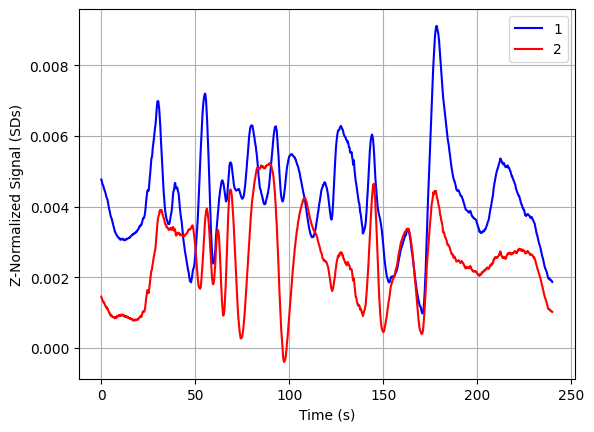

In [24]:
fig, ax = plt.subplots()
#ax.plot(timestamps,np.add(signal_1x, signal_2x), "b-")

ax.plot(timestamps,signal_1, "b-")
ax.plot(timestamps,signal_2, "r-")
ax.grid()
#ax.set_ylim([0, np.max(signal_2)])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Z-Normalized Signal (SDs)")
plt.legend(["1", "2"])
plt.show()


In [23]:
s1sd = np.std(signal_1)
s2sd = np.std(signal_2)
print("{:e}".format(s1sd))
print("{:e}".format(s2sd))

1.388285e-03
1.177789e-03


In [78]:
s1b4sd = np.std(signal_1b4)
s2b4sd = np.std(signal_2b4)
print("{:e}".format(s1b4sd))
print("{:e}".format(s2b4sd))

data = [s1sd+s2sd,s1b4sd+s2b4sd]

5.783740e-04
5.343973e-04


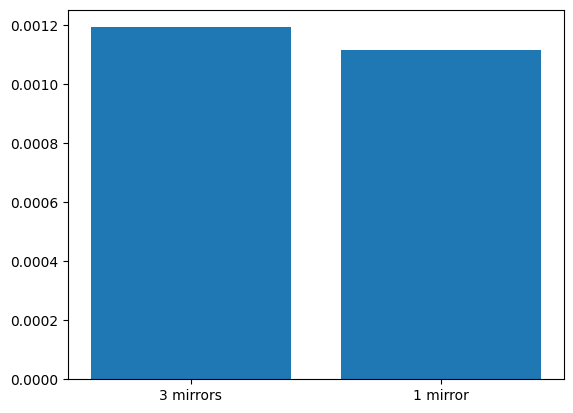

In [43]:
plt.bar(["3 mirrors","1 mirror"],data)
plt.show()

In [13]:
amp1.write("OFLT 8")
amp2.write("OFLT 9")
time.sleep(0.5)
data_8_9 = bestLockinParaEstimate(amp1, amp2, 0.3)

amp1.write("OFLT 10")
amp2.write("OFLT 11")
time.sleep(0.5)
data_10_11 = bestLockinParaEstimate(amp1, amp2, 3)

Starting 120 seccond measurement....
Done
Starting 120 seccond measurement....
Done
Starting 120 seccond measurement....
Done
Starting 120 seccond measurement....
Done
Finished
Starting 120 seccond measurement....
Done
Starting 120 seccond measurement....
Done
Starting 120 seccond measurement....
Done
Starting 120 seccond measurement....
Done
Finished


In [17]:
data_10_11

{'6': [0.0007187707264318391, 0.0002993116003654928],
 '12': [0.0006302401521916848, 0.00022060701216075257],
 '18': [0.00039966753076892705, 0.0003945853386034494],
 '24': [0.0002608090841770647, 0.000208106887501604]}

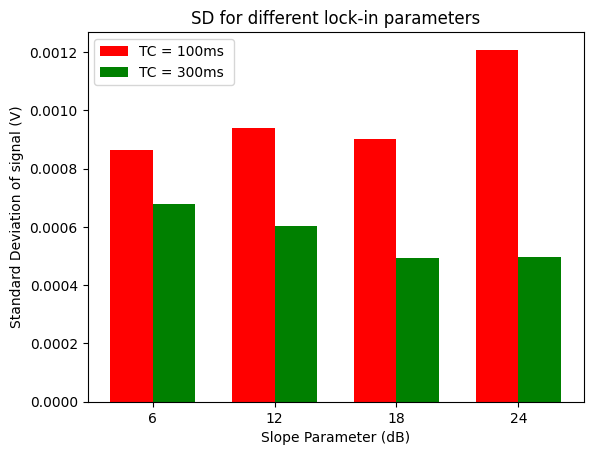

In [18]:

keys = list(data_8_9.keys())
# Get a list of first elements from each array
values1 = [value[0] for value in data_8_9.values()]

# Get a list of second elements from each array
values2 = [value[1] for value in data_8_9.values()]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the first bar plot
bar_width = 0.35
bar1 = ax.bar(np.arange(len(keys)), values1, bar_width, color='red')

# Create the second bar plot and shift it to the right
bar2 = ax.bar(np.arange(len(keys)) + bar_width, values2, bar_width, color='green')

ax.set_xlabel('Slope Parameter (dB)')
ax.set_ylabel('Standard Deviation of signal (V)')
ax.set_title('SD for different lock-in parameters')
ax.set_xticks(np.arange(len(keys)) + bar_width / 2)
ax.set_xticklabels(keys)

# Add legend
ax.legend((bar1[0], bar2[0]), ('TC = 100ms ', 'TC = 300ms'))


plt.show()

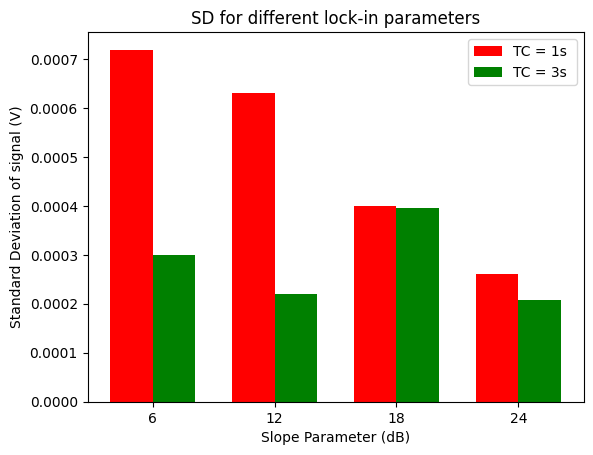

In [19]:
data_10_11

keys = list(data_10_11.keys())
# Get a list of first elements from each array
values1 = [value[0] for value in data_10_11.values()]

# Get a list of second elements from each array
values2 = [value[1] for value in data_10_11.values()]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the first bar plot
bar_width = 0.35
bar1 = ax.bar(np.arange(len(keys)), values1, bar_width, color='red')

# Create the second bar plot and shift it to the right
bar2 = ax.bar(np.arange(len(keys)) + bar_width, values2, bar_width, color='green')

ax.set_xlabel('Slope Parameter (dB)')
ax.set_ylabel('Standard Deviation of signal (V)')
ax.set_title('SD for different lock-in parameters')
ax.set_xticks(np.arange(len(keys)) + bar_width / 2)
ax.set_xticklabels(keys)

# Add legend
ax.legend((bar1[0], bar2[0]), ('TC = 1s ', 'TC = 3s'))


plt.show()

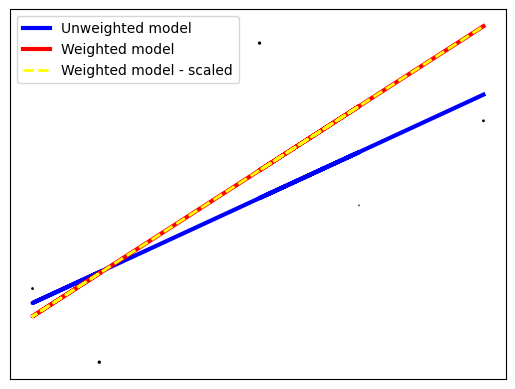

In [29]:
# Load the diabetes dataset
X = np.random.rand(5,1)
y = np.random.rand(5,1)
n_samples = 5

# Create equal weights and then augment the last 2 ones
sample_weight = np.array([2, 1, 0.1, 2, 1]) 


plt.scatter(X, y, s=sample_weight, c='grey', edgecolor='black')

# The unweighted model
regr = LinearRegression()
regr.fit(X, y)
plt.plot(X, regr.predict(X), color='blue', linewidth=3, label='Unweighted model')

# The weighted model
regr = LinearRegression()
regr.fit(X, y, sample_weight)
plt.plot(X, regr.predict(X), color='red', linewidth=3, label='Weighted model')

In [40]:
regr.coef_
regr.intercept_

array([0.29805082])